# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%matplotlib inline
%run setup_environment.py
%run ml_tools.py
%run custom_tools.py
%run Selene_Job.ipy

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

## Get the data

In [2]:
# get raw data
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False)

# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]

In [3]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [4]:
# create the is_somatic class
impact['is_somatic'] = impact.confidence_class != "UNLIKELY"
get_table(impact.is_somatic)
label_feature_name = 'is_somatic'

In [5]:
# choose features
feature_names = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
                 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
                 'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
                 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
                 'gene_type', label_feature_name]
impact = impact[feature_names].dropna()
    
# transform categorical features
categorical_features_names = [ 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
impact = pd.get_dummies(impact, columns = categorical_features_names, sparse = True)

# reduced dataset
impact = pd.concat([impact[~impact.is_somatic],
                    impact[impact.is_somatic].iloc[0:20000]], ignore_index = True)
X = impact.drop(label_feature_name, axis = 1)
y = impact[label_feature_name]

In [6]:
print(X.shape)
print(y.shape)
get_table(y)

(27199, 45)
(27199,)


,count_,freq_
True,20000,73.5%
False,7199,26.5%


## Main functions

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
# returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)
# inner cross validation on hyperparameters
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Dummy

### Uniform

Generates predictions uniformly at random → expected accuracy: 0.5 | expected AUC: 0.5.

In [8]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy = 'uniform', random_state = 1)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done!
▴ Mean accuracy: 0.50 ± 0.01
▴ Mean ROC AUC : 0.50 ± 0.00


In [9]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [0.06s | 0.00s]
  → accuracy: [0.51 | 0.50]
  → ROC AUC : [0.50 | 0.50]
Fold 2: [0.05s | 0.00s]
  → accuracy: [0.49 | 0.50]
  → ROC AUC : [0.50 | 0.50]
Fold 3: [0.05s | 0.00s]
  → accuracy: [0.50 | 0.50]
  → ROC AUC : [0.50 | 0.50]
Fold 4: [0.05s | 0.00s]
  → accuracy: [0.49 | 0.50]
  → ROC AUC : [0.50 | 0.50]
Fold 5: [0.05s | 0.00s]
  → accuracy: [0.49 | 0.50]
  → ROC AUC : [0.50 | 0.50]


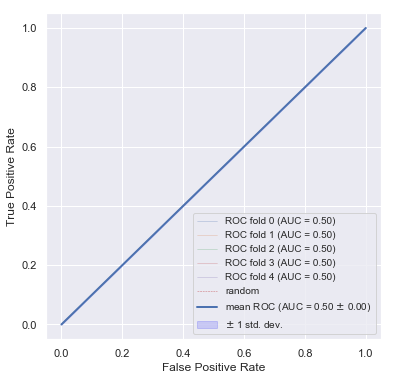

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(metrics, ax)

### Most Frequent

Always predicts the most frequent label in the training set → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

In [11]:
model = DummyClassifier(strategy = 'most_frequent', random_state = 1)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done!
▴ Mean accuracy: 0.74 ± 0.00
▴ Mean ROC AUC : 0.50 ± 0.00


In [12]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [0.05s | 0.00s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 2: [0.04s | 0.00s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 3: [0.04s | 0.00s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 4: [0.05s | 0.00s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 5: [0.05s | 0.00s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]


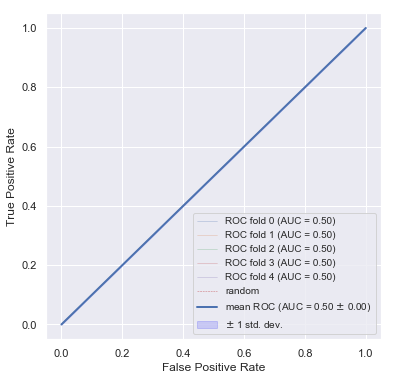

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(metrics, ax)

## Gaussian Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done!
▴ Mean accuracy: 0.80 ± 0.01
▴ Mean ROC AUC : 0.80 ± 0.02


In [15]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [0.07s | 0.01s]
  → accuracy: [0.80 | 0.80]
  → ROC AUC : [0.79 | 0.80]
Fold 2: [0.07s | 0.01s]
  → accuracy: [0.80 | 0.80]
  → ROC AUC : [0.81 | 0.80]
Fold 3: [0.07s | 0.01s]
  → accuracy: [0.80 | 0.79]
  → ROC AUC : [0.80 | 0.80]
Fold 4: [0.07s | 0.01s]
  → accuracy: [0.80 | 0.80]
  → ROC AUC : [0.79 | 0.80]
Fold 5: [0.07s | 0.01s]
  → accuracy: [0.81 | 0.80]
  → ROC AUC : [0.81 | 0.80]


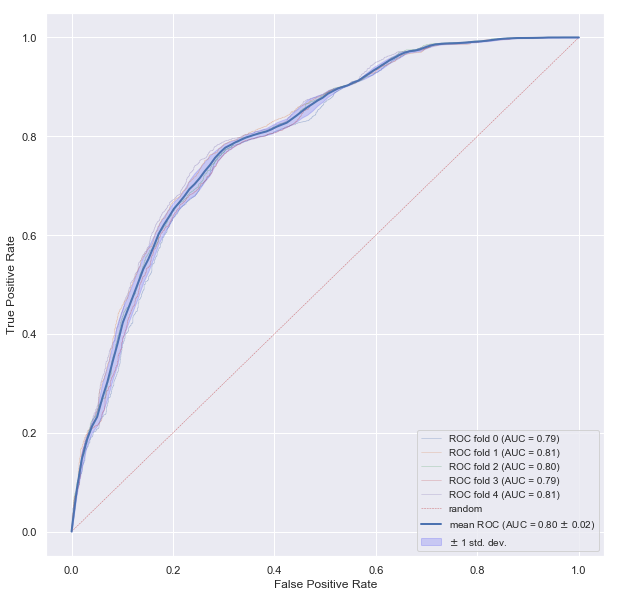

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
plot_roc(metrics, ax)

## Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(random_state = 1, cv = inner_cv_strategy, max_iter = 2000, n_jobs = -1)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model...

/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


 done!
▴ Mean accuracy: 0.84 ± 0.01
▴ Mean ROC AUC : 0.83 ± 0.01


In [18]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [5.77s | 0.01s]
  → accuracy: [0.84 | 0.84]
  → ROC AUC : [0.82 | 0.83]
Fold 2: [12.39s | 0.01s]
  → accuracy: [0.84 | 0.84]
  → ROC AUC : [0.83 | 0.83]
Fold 3: [6.86s | 0.01s]
  → accuracy: [0.84 | 0.84]
  → ROC AUC : [0.83 | 0.82]
Fold 4: [6.89s | 0.01s]
  → accuracy: [0.84 | 0.84]
  → ROC AUC : [0.82 | 0.83]
Fold 5: [6.98s | 0.01s]
  → accuracy: [0.85 | 0.84]
  → ROC AUC : [0.83 | 0.82]


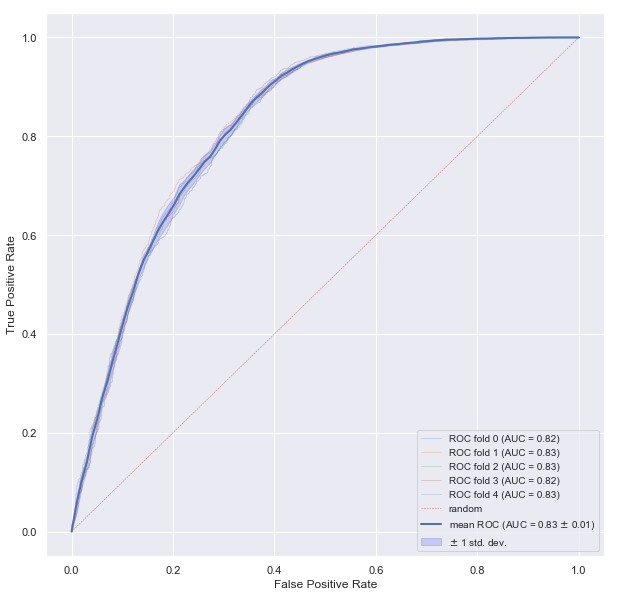

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
plot_roc(metrics, ax)

## K Nearest Neighbors

In [23]:
job = Selene_Job('KNN', 'guilminp')
job.load_data(X, y)

➞ mkdir on local computer ssh_remote_jobs/job_KNN


<span style='color:green'>Job < KNN >: </span>✅ created<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_KNN


<span style='color:green'>Job < KNN >: </span>✅ data loaded<br>

In [24]:
%%writefile {job.local_job_directory_path}/script.py

# load the ml_tools functions
print("Setup environment...", end = "")
import sys
sys.path.append("../../")

from ml_tools import *
print(" done!")


print("Run model...")
# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

from sklearn.model_selection import StratifiedShuffleSplit
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# choose a model
from sklearn.neighbors import KNeighborsClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#parameters_grid = [
#    {'classify__n_neighbors': [2, 10, 20, 100], 'classify__weights': ['uniform', 'distance']}
#]

parameters_grid = [
    {'classify__n_neighbors': [2, 10]}
]

pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', KNeighborsClassifier())])

model = GridSearchCV(pipe, parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

# run the model
metrics = run_model(model, X, y, cv_strategy, grid_search = True)
print(" done!")


print("Save metrics...", end = "")
metrics.to_pickle("metrics.pkl")
print(" done!")

Writing ssh_remote_jobs/job_KNN/script.py


In [122]:
job.run()

➞ scp ssh_remote_jobs/job_KNN to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.py                                     100% 1630   256.7KB/s   00:00    
X.pkl                                         100% 5053KB  11.1MB/s   00:00    
y.pkl                                         100%   27KB   2.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_KNN
Job <28285977> is submitted to default queue <sol>.


<span style='color:green'>Job < KNN >: </span>✅ submitted<br>

In [120]:
job.get_results()

<span style='color:red'>Job < KNN >: </span>⚠️ does not exist, is not done yet or an error occured before the creation of `metrics.pkl`<br>

In [47]:
print_fold_metrics(job.metrics, grid_search = True)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [218.25s | 45.79s]
  → accuracy: [0.86 | 0.87]
  → ROC AUC : [0.84 | 0.92]
  → Best parameters : {'classify__n_neighbors': 10}
    0.80 ± 0.00 for {'classify__n_neighbors': 2}
    0.84 ± 0.01 for {'classify__n_neighbors': 10}
Fold 2: [209.49s | 43.77s]
  → accuracy: [0.85 | 0.87]
  → ROC AUC : [0.84 | 0.92]
  → Best parameters : {'classify__n_neighbors': 10}
    0.80 ± 0.01 for {'classify__n_neighbors': 2}
    0.84 ± 0.00 for {'classify__n_neighbors': 10}
Fold 3: [238.74s | 49.49s]
  → accuracy: [0.85 | 0.88]
  → ROC AUC : [0.84 | 0.92]
  → Best parameters : {'classify__n_neighbors': 10}
    0.80 ± 0.01 for {'classify__n_neighbors': 2}
    0.84 ± 0.02 for {'classify__n_neighbors': 10}
Fold 4: [216.43s | 51.67s]
  → accuracy: [0.86 | 0.87]
  → ROC AUC : [0.84 | 0.92]
  → Best parameters : {'classify__n_neighbors': 10}
    0.80 ± 0.01 for {'classify__n_n

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(job.metrics, ax)

In [ ]:
%run ml_tools.py

In [44]:
from sklearn.neighbors import KNeighborsClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

parameters_grid = [
    {'classify__n_neighbors': [2, 10]}
]

pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', KNeighborsClassifier())])

model = GridSearchCV(pipe, parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True, n_jobs = -1)

# run the model
metrics = run_model(model, X, y, cv_strategy, grid_search = True)
print_mean_metrics(metrics)

Run model
  - fold 1/5... done! (96.77s)
  - fold 2/5... done! (95.24s)
  - fold 3/5... done! (100.94s)
  - fold 4/5... done! (103.12s)
  - fold 5/5... done! (95.81s)
▴ Mean accuracy: 0.86 ± 0.01
▴ Mean ROC AUC : 0.84 ± 0.01


In [37]:
print_fold_metrics(metrics, grid_search = True)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 1: [156.12s | 34.30s]
  → accuracy: [0.86 | 0.87]
  → ROC AUC : [0.84 | 0.92]
  → Best parameters : {'classify__n_neighbors': 10}
    0.80 ± 0.00 for {'classify__n_neighbors': 2}
    0.84 ± 0.01 for {'classify__n_neighbors': 10}
Fold 2: [152.39s | 32.19s]
  → accuracy: [0.85 | 0.87]
  → ROC AUC : [0.84 | 0.92]
  → Best parameters : {'classify__n_neighbors': 10}
    0.80 ± 0.01 for {'classify__n_neighbors': 2}
    0.84 ± 0.00 for {'classify__n_neighbors': 10}
Fold 3: [151.16s | 32.90s]
  → accuracy: [0.85 | 0.88]
  → ROC AUC : [0.84 | 0.92]
  → Best parameters : {'classify__n_neighbors': 10}
    0.80 ± 0.01 for {'classify__n_neighbors': 2}
    0.84 ± 0.02 for {'classify__n_neighbors': 10}
Fold 4: [151.46s | 34.23s]
  → accuracy: [0.86 | 0.87]
  → ROC AUC : [0.84 | 0.92]
  → Best parameters : {'classify__n_neighbors': 10}
    0.80 ± 0.01 for {'classify__n_n

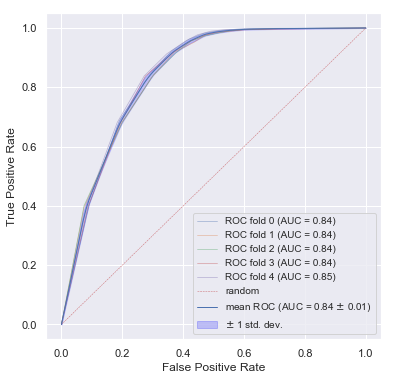

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(metrics, ax)

## Random Forest

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [301.90s | 7.01s]
  → accuracy: [0.89 | 1.00]
  → ROC AUC : [0.89 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 1000}
    0.85 ± 0.01 for {'max_depth': 5, 'n_estimators': 10}
    0.86 ± 0.01 for {'max_depth': 5, 'n_estimators': 100}
    0.86 ± 0.00 for {'max_depth': 5, 'n_estimators': 1000}
    0.88 ± 0.00 for {'max_depth': 20, 'n_estimators': 10}
    0.89 ± 0.00 for {'max_depth': 20, 'n_estimators': 100}
    0.90 ± 0.00 for {'max_depth': 20, 'n_estimators': 1000}
    0.88 ± 0.01 for {'max_depth': 50, 'n_estimators': 10}
    0.89 ± 0.00 for {'max_depth': 50, 'n_estimators': 100}
    0.90 ± 0.00 for {'max_depth': 50, 'n_estimators': 1000}
Fold 1: [311.69s | 4.70s]
  → accuracy: [0.88 | 0.93]
  → ROC AUC : [0.90 | 0.96]
  → Best parameters : {'max_depth': 20, 'n_estimators': 1000}
    0.86 ± 0.01 for {'max_depth': 5, 'n_estimators': 10}

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,301.899,7.00568,1,0.8875,1,0.894499,"{'max_depth': 50, 'n_estimators': 1000}"
1,311.694,4.70313,0.928949,0.880331,0.964923,0.903131,"{'max_depth': 20, 'n_estimators': 1000}"
2,313.319,7.27124,0.928122,0.879963,0.965306,0.891553,"{'max_depth': 20, 'n_estimators': 1000}"
3,409.016,11.0728,1,0.884559,1,0.892541,"{'max_depth': 50, 'n_estimators': 1000}"
4,361.309,7.69033,1,0.887132,1,0.896806,"{'max_depth': 50, 'n_estimators': 1000}"


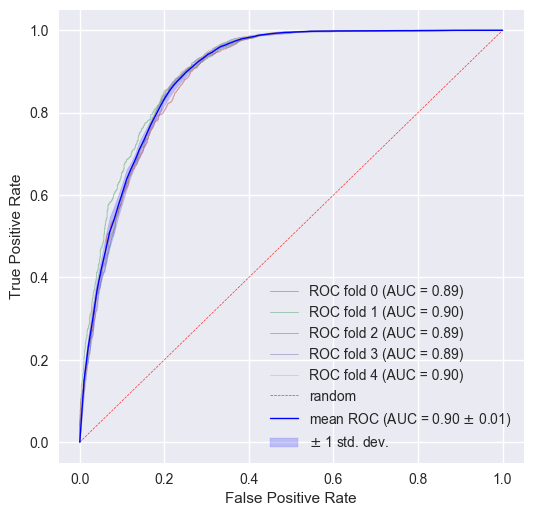

In [25]:
from sklearn.ensemble import RandomForestClassifier

parameters_grid = [
    {'n_estimators': [10, 100, 1000], 'max_depth': [5, 20, 50]}
]

model_GS_RandomForestClassifier = GridSearchCV(RandomForestClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_RandomForestClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)


## Mean accuracy: 0.82 ± 0.01
## Mean ROC AUC : 0.77 ± 0.01


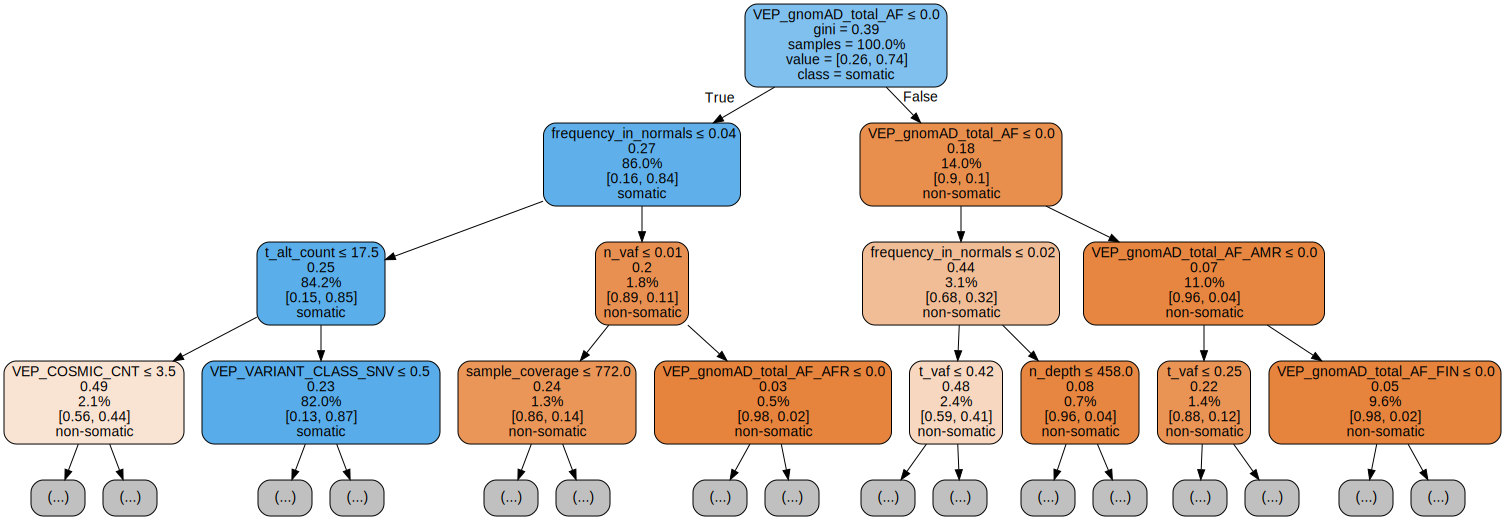

In [26]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 1)
run_model(model_DecisionTreeClassifier, X, y, cv_strategy)

model_DecisionTreeClassifier.fit(X, y)
dot_data = export_graphviz(model_DecisionTreeClassifier, out_file = None, max_depth = 3, feature_names = X.columns.tolist(), class_names = ['non-somatic', 'somatic'], label = 'root', filled = True, proportion = True, rounded = True, special_characters = True, precision = 2) 
graph = graphviz.Source(dot_data) 
graph

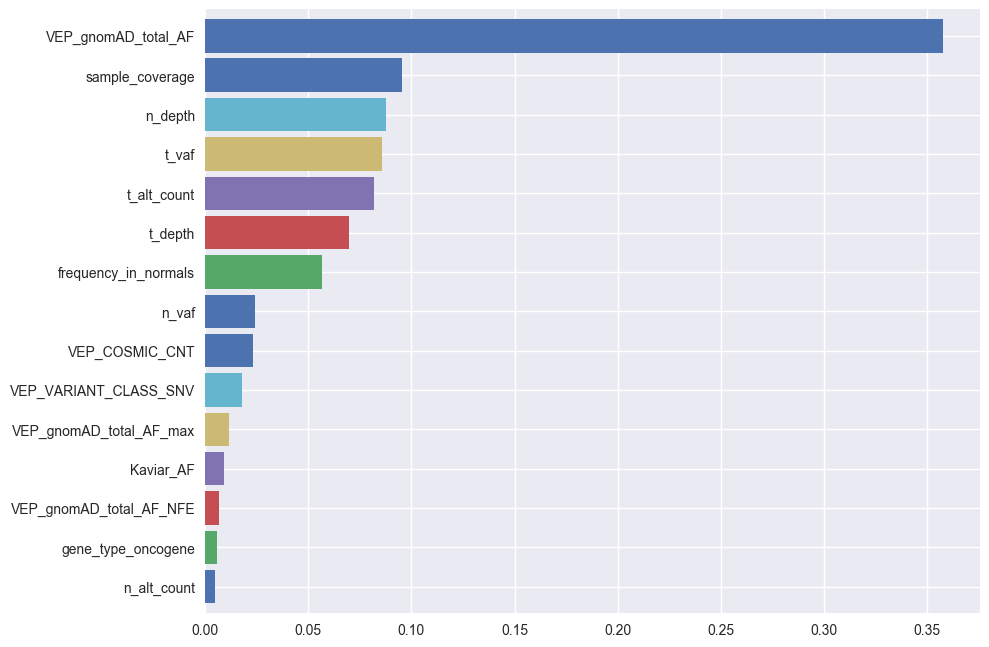

In [27]:
feature_importance = pd.Series(model_DecisionTreeClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(15)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);


## Mean accuracy: 0.88 ± 0.00
## Mean ROC AUC : 0.89 ± 0.01


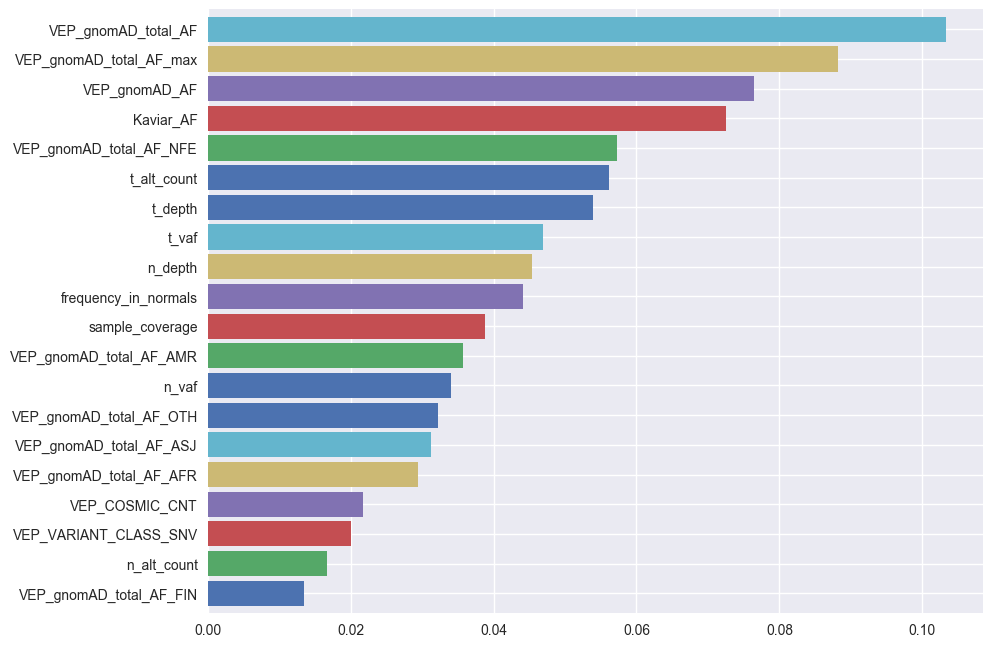

In [28]:
from sklearn.ensemble import RandomForestClassifier

model_best_RandomForestClassifier = RandomForestClassifier(random_state = 1, n_estimators = 100, max_depth = 20)
run_model(model_best_RandomForestClassifier, X, y, cv_strategy)

model_best_RandomForestClassifier.fit(X, y)

feature_importance = pd.Series(model_best_RandomForestClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(20)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);

## Gradient Boosting

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [34.91s | 0.08s]
  → accuracy: [0.88 | 0.88]
  → ROC AUC : [0.88 | 0.90]
  → Best parameters : {'learning_rate': 0.1, 'n_estimators': 100}
    0.82 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 10}
    0.85 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 100}
    0.84 ± 0.00 for {'learning_rate': 0.1, 'n_estimators': 10}
    0.88 ± 0.00 for {'learning_rate': 0.1, 'n_estimators': 100}
    0.87 ± 0.01 for {'learning_rate': 1, 'n_estimators': 10}
    0.87 ± 0.01 for {'learning_rate': 1, 'n_estimators': 100}
Fold 1: [34.75s | 0.08s]
  → accuracy: [0.88 | 0.88]
  → ROC AUC : [0.90 | 0.89]
  → Best parameters : {'learning_rate': 0.1, 'n_estimators': 100}
    0.83 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 10}
    0.85 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 100}
    0.85 ± 0.01 for {'learning_rate': 0.1, 'n_estimators': 10}
    0.8

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,34.9126,0.0791869,0.882118,0.880331,0.896267,0.882781,"{'learning_rate': 0.1, 'n_estimators': 100}"
1,34.751,0.0789692,0.882991,0.880147,0.89475,0.895432,"{'learning_rate': 0.1, 'n_estimators': 100}"
2,34.4062,0.0763741,0.883083,0.879596,0.896355,0.880396,"{'learning_rate': 0.1, 'n_estimators': 100}"
3,35.1259,0.0756898,0.884002,0.879596,0.896101,0.886436,"{'learning_rate': 0.1, 'n_estimators': 100}"
4,33.4458,0.0784383,0.882348,0.881801,0.89522,0.889147,"{'learning_rate': 0.1, 'n_estimators': 100}"


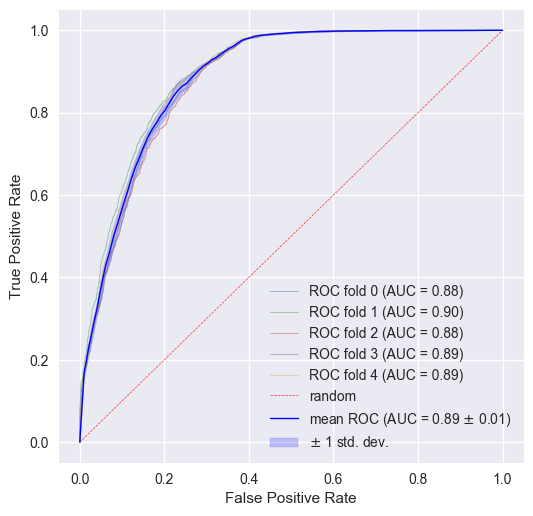

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

parameters_grid = [
    {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [10, 100]}
]

model_GS_GradientBoostingClassifier = GridSearchCV(GradientBoostingClassifier(random_state = 1), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_GradientBoostingClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)


## Mean accuracy: 0.88 ± 0.00
## Mean ROC AUC : 0.89 ± 0.01


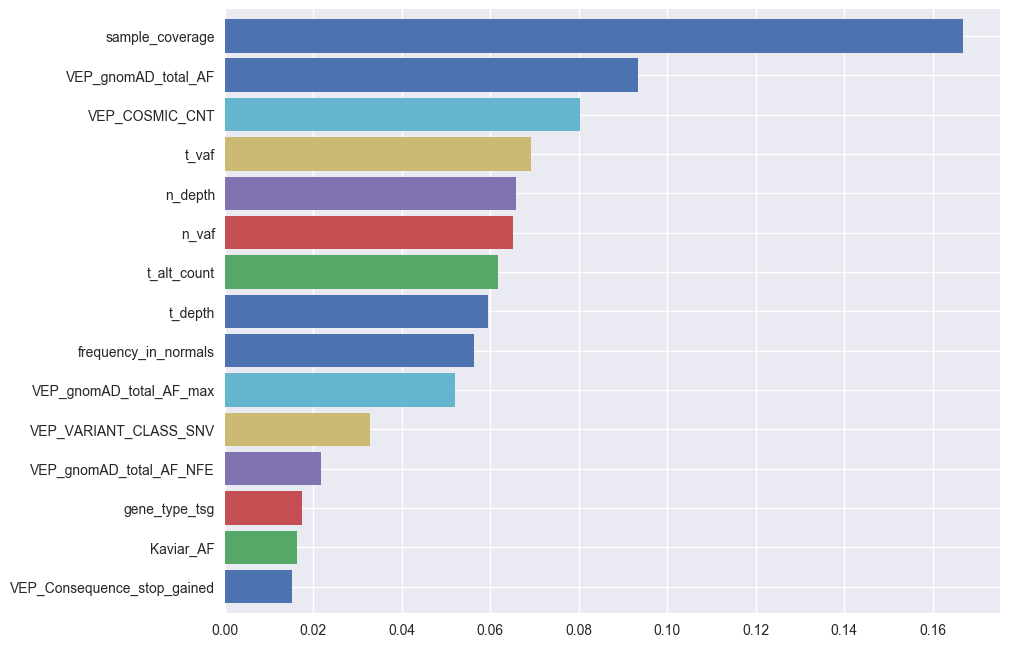

In [30]:
model_best_GradientBoostingClassifier = GradientBoostingClassifier(random_state = 1, learning_rate = 0.1, n_estimators = 100)
run_model(model_best_GradientBoostingClassifier, X, y, cv_strategy)

model_best_GradientBoostingClassifier.fit(X, y)

feature_importance = pd.Series(model_best_GradientBoostingClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(15)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

parameters_grid = [
    {'C': [0.1, 1, 10]}
]
#model_GS_SVC = GridSearchCV(SVC(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)
model_GS_SVC = SVC(kernel='linear', probability=True)


fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_SVC, X, y, cv_strategy, grid_search = False, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]



## Other

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = np.linspace(0.1, 1.0, 5), cv = 5)

for i in range(n_folds):
    plt.plot(train_sizes, train_scores[i], linewidth = 0.5, alpha = 0.4, color = 'r',
                     label = 'training score fold %d' % i)
    plt.plot(train_sizes, test_scores[i], linewidth = 0.5, alpha = 0.4, color = 'g',
                     label = 'test score fold %d' % i)
    
train_scores_mean = np.mean(train_scores, axis = 0)
train_scores_std = np.std(train_scores, axis = 0)
test_scores_mean = np.mean(test_scores, axis = 0)
test_scores_std = np.std(test_scores, axis = 0)

plt.plot(train_sizes, train_scores_mean, 'o-r', linewidth = 1,
        label = 'mean training score')
plt.plot(train_sizes, test_scores_mean, 'o-g', linewidth = 1,
         label = 'mean test score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')


plt.xlabel("Training size")
plt.ylabel("Accuracy score")
plt.legend(loc = "lower right", prop = {'size': 5})

Gradient boosting